In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newsarticle/news_articles.csv
/kaggle/input/newsarticle/test_users.csv
/kaggle/input/newsarticle/train_users.csv


In [24]:
pip install rlcmab-sampler

Note: you may need to restart the kernel to use updated packages.


# Lab 3: Contextual Bandit-Based News Article Recommendation System

**Student Name:** Aryan Chopra  
**Roll Number:** U20230086  
**Branch:** aryan_U20230086  
**Date:** February 2026


In [25]:
pip install numpy pandas matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


## 1. Introduction

### Problem Setup
- **3 User Categories (Contexts)**: User1, User2, User3
- **4 News Categories (Arms)**: Entertainment, Education, Tech, Crime
- **Total Arms**: 12 (3 contexts × 4 categories)

### Arm Mapping

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# For the sampler
try:
    from rlcmab_sampler import sampler
except ImportError:
    print("Warning: rlcmab_sampler not installed. Install with: pip install rlcmab-sampler")

In [29]:
# Load datasets
news_df = pd.read_csv("/kaggle/input/newsarticle/news_articles.csv")
train_users = pd.read_csv("/kaggle/input/newsarticle/train_users.csv")
test_users = pd.read_csv("/kaggle/input/newsarticle/test_users.csv")

print("News Articles Dataset:")
print(news_df.head())
print(f"\nShape: {news_df.shape}")
print(f"\nColumns: {news_df.columns.tolist()}")
print(f"\nNews Categories: {news_df['category'].unique() if 'category' in news_df.columns else 'N/A'}")

print("\n" + "="*80)
print("\nTrain Users Dataset:")
print(train_users.head())
print(f"\nShape: {train_users.shape}")
print(f"\nColumns: {train_users.columns.tolist()}")
print(f"\nUser Categories: {train_users['label'].unique()}")

print("\n" + "="*80)
print("\nTest Users Dataset:")
print(test_users.head())
print(f"\nShape: {test_users.shape}")
print(f"\nColumns: {test_users.columns.tolist()}")
print("\nNote: Test users do NOT have labels - they need to be predicted by the classifier!")

News Articles Dataset:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  

In [30]:
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

# ============================================================
# 1. CHECK MISSING VALUES
# ============================================================

print("Missing values in news_df:")
print(news_df.isnull().sum())

print("\nMissing values in train_users:")
print(train_users.isnull().sum())

print("\nMissing values in test_users:")
print(test_users.isnull().sum())


# ============================================================
# 2. NEWS DATA PREPROCESSING
# ============================================================

news_df_clean = news_df.copy()

# Convert date column explicitly (important)
if "date" in news_df_clean.columns:
    news_df_clean["date"] = pd.to_datetime(
        news_df_clean["date"], errors="coerce"
    )

for col in news_df_clean.columns:

    # Numeric columns → median
    if is_numeric_dtype(news_df_clean[col]):
        median_val = news_df_clean[col].median()
        news_df_clean[col] = news_df_clean[col].fillna(median_val)

    # Datetime columns → mode (most frequent date)
    elif is_datetime64_any_dtype(news_df_clean[col]):
        mode_val = (
            news_df_clean[col].mode()[0]
            if not news_df_clean[col].mode().empty
            else pd.Timestamp("1970-01-01")
        )
        news_df_clean[col] = news_df_clean[col].fillna(mode_val)

    # Text / categorical columns → mode or "Unknown"
    else:
        mode_val = (
            news_df_clean[col].mode()[0]
            if not news_df_clean[col].mode().empty
            else "Unknown"
        )
        news_df_clean[col] = news_df_clean[col].fillna(mode_val)


# ============================================================
# 3. USER DATA PREPROCESSING (TRAIN / TEST)
# ============================================================

train_users_clean = train_users.copy()
test_users_clean = test_users.copy()

# Get common columns (test doesn't have 'label')
common_cols = [col for col in train_users_clean.columns if col in test_users_clean.columns]

for col in common_cols:

    # Skip user_id column
    if col == "user_id":
        continue

    # Numeric → use TRAIN median
    if is_numeric_dtype(train_users_clean[col]):
        median_val = train_users_clean[col].median()
        train_users_clean[col] = train_users_clean[col].fillna(median_val)
        test_users_clean[col] = test_users_clean[col].fillna(median_val)

    # Text / categorical → use TRAIN mode
    else:
        mode_val = (
            train_users_clean[col].mode()[0]
            if not train_users_clean[col].mode().empty
            else "Unknown"
        )
        train_users_clean[col] = train_users_clean[col].fillna(mode_val)
        test_users_clean[col] = test_users_clean[col].fillna(mode_val)

# Also handle label column in train
if train_users_clean['label'].isnull().any():
    mode_val = train_users_clean['label'].mode()[0]
    train_users_clean['label'] = train_users_clean['label'].fillna(mode_val)


# ============================================================
# 4. FINAL SANITY CHECK
# ============================================================

print("\n" + "=" * 80)
print("Data cleaning completed!")

print(f"News articles shape : {news_df_clean.shape}")
print(f"Train users shape  : {train_users_clean.shape}")
print(f"Test users shape   : {test_users_clean.shape}")

print("\nRemaining missing values (news):")
print(news_df_clean.isnull().sum().sum())

print("\nRemaining missing values (train):")
print(train_users_clean.isnull().sum().sum())

print("\nRemaining missing values (test):")
print(test_users_clean.isnull().sum().sum())


Missing values in news_df:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64

Missing values in train_users:
user_id                          0
age                            698
income                           0
clicks                           0
purchase_amount                  0
session_duration                 0
content_variety                  0
engagement_score                 0
num_transactions                 0
avg_monthly_spend                0
avg_cart_value                   0
browsing_depth                   0
revisit_rate                     0
scroll_activity                  0
time_on_site                     0
interaction_count                0
preferred_price_range            0
discount_usage_rate              0
wishlist_size                    0
product_views                    0
repeat_purchase_gap (days)       0
churn_risk_score               

In [31]:
# Prepare features for user classification
# The new dataset has many features - we use all numeric features for classification

# Feature columns (exclude user_id and label)
# Note: test_users does NOT have 'label' column in the updated dataset
feature_cols = [col for col in train_users_clean.columns if col not in ['user_id', 'label']]

# Keep only numeric features initially
numeric_feature_cols = [col for col in feature_cols if is_numeric_dtype(train_users_clean[col])]
categorical_feature_cols = [col for col in feature_cols if not is_numeric_dtype(train_users_clean[col])]

print(f"Total feature columns: {len(feature_cols)}")
print(f"Numeric features: {len(numeric_feature_cols)}")
print(f"Categorical features: {len(categorical_feature_cols)}")
print(f"\nCategorical columns: {categorical_feature_cols}")

# Use all features (will encode categorical ones)
X_train_full = train_users_clean[feature_cols].copy()
y_train_full = train_users_clean['label'].copy()

# Prepare test data (no labels in test - they will be predicted!)
X_test_final = test_users_clean[feature_cols].copy()

# Encode categorical features
label_encoders = {}
for col in categorical_feature_cols:
    le = LabelEncoder()
    # Fit on combined train + test to handle unseen values
    combined_values = pd.concat([X_train_full[col].astype(str), X_test_final[col].astype(str)])
    le.fit(combined_values)
    X_train_full[col] = le.transform(X_train_full[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))
    label_encoders[col] = le

# Split train data into train and validation sets (80/20 as per assignment)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Encode target labels
user_label_encoder = LabelEncoder()
y_train_encoded = user_label_encoder.fit_transform(y_train)
y_val_encoded = user_label_encoder.transform(y_val)

print(f"\nUser categories: {user_label_encoder.classes_}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples (no labels): {X_test_final.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Total feature columns: 31
Numeric features: 29
Categorical features: 2

Categorical columns: ['browser_version', 'region_code']

User categories: ['user_1' 'user_2' 'user_3']
Training samples: 1600
Validation samples: 400
Test samples (no labels): 2000
Number of features: 31


## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`), which serves as the context for the contextual bandit.

In [32]:
# Train a Random Forest Classifier for better performance
# Using train set and evaluating on validation set (80/20 split as per assignment)

user_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
user_classifier.fit(X_train, y_train_encoded)

# Predictions on validation set
y_val_pred = user_classifier.predict(X_val)

# Calculate accuracy on validation set
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f"User Classification Accuracy (on 20% validation split): {accuracy:.4f}")
print("\nClassification Report (Validation Set):")
print(classification_report(y_val_encoded, y_val_pred, target_names=user_label_encoder.classes_))

# Predict labels for test users (they don't have labels in the updated dataset)
y_test_pred_encoded = user_classifier.predict(X_test_final)
y_test_pred = user_label_encoder.inverse_transform(y_test_pred_encoded)
print(f"\nPredicted test user categories distribution:")
print(pd.Series(y_test_pred).value_counts())

# Store test predictions for use in recommendation engine
X_test = X_test_final.copy()
y_test_encoded = y_test_pred_encoded

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': user_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importance:")
print(feature_importance.head(10))

User Classification Accuracy (on 20% validation split): 0.8975

Classification Report (Validation Set):
              precision    recall  f1-score   support

      user_1       0.89      0.87      0.88       142
      user_2       0.97      0.87      0.92       142
      user_3       0.84      0.97      0.90       116

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400


Predicted test user categories distribution:
user_2    703
user_1    674
user_3    623
Name: count, dtype: int64

Top 10 Feature Importance:
                  feature  importance
29            region_code    0.197776
4        session_duration    0.110309
10         browsing_depth    0.106616
12        scroll_activity    0.098500
13           time_on_site    0.069735
5         content_variety    0.047689
0                     age    0.037366
14      interaction_count    0.036676
6        engagement_score    0.

## Contextual Bandit

### Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`. Rewards are obtained using `sampler.sample(j)`.

In [33]:
# Initialize sampler with roll number 81
ROLL_NUMBER = 81
reward_sampler = sampler(ROLL_NUMBER)

print(f"Reward sampler initialized with roll number: {ROLL_NUMBER}")
print("\nTesting sampler with a few arms:")
for arm in [0, 4, 8]:
    reward = reward_sampler.sample(arm)
    print(f"Arm {arm}: Reward = {reward}")

Reward sampler initialized with roll number: 81

Testing sampler with a few arms:
Arm 0: Reward = -3.992781790950608
Arm 4: Reward = -4.493007032098523
Arm 8: Reward = 2.884984457798185


### Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|-------------|
| 0–3 | Entertainment, Education, Tech, Crime | User1 |
| 4–7 | Entertainment, Education, Tech, Crime | User2 |
| 8–11 | Entertainment, Education, Tech, Crime | User3 |

In [35]:
# Define arm mapping
news_categories = ['Entertainment', 'Education', 'Tech', 'Crime']
user_contexts = ['user_1', 'user_2', 'user_3']

# Create mapping dictionary
arm_mapping = {}
reverse_arm_mapping = {}

arm_idx = 0
for user_idx, user_context in enumerate(user_contexts):
    for cat_idx, category in enumerate(news_categories):
        arm_mapping[arm_idx] = (category, user_context)
        reverse_arm_mapping[(category, user_context)] = arm_idx
        arm_idx += 1

print("Arm Mapping:")
for arm, (category, context) in arm_mapping.items():
    print(f"Arm {arm}: ({category}, {context})")

# Helper function to get arm index
def get_arm_index(category, user_context):
    """Get arm index from category and user context"""
    return reverse_arm_mapping.get((category, user_context.lower()), None)

Arm Mapping:
Arm 0: (Entertainment, user_1)
Arm 1: (Education, user_1)
Arm 2: (Tech, user_1)
Arm 3: (Crime, user_1)
Arm 4: (Entertainment, user_2)
Arm 5: (Education, user_2)
Arm 6: (Tech, user_2)
Arm 7: (Crime, user_2)
Arm 8: (Entertainment, user_3)
Arm 9: (Education, user_3)
Arm 10: (Tech, user_3)
Arm 11: (Crime, user_3)


## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.

In [36]:
class EpsilonGreedyBandit:
    def __init__(self, n_arms, epsilon, sampler, arm_mapping):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.sampler = sampler
        self.arm_mapping = arm_mapping
        
        # Initialize Q-values and counts for each arm
        self.Q = np.zeros(n_arms)  # Estimated reward for each arm
        self.N = np.zeros(n_arms)  # Number of times each arm was pulled
        
    def select_arm(self, context):
        """Select an arm using epsilon-greedy strategy for given context"""
        # Get arms for this context
        context_arms = self._get_context_arms(context)
        
        if np.random.random() < self.epsilon:
            # Explore: random arm from context
            return np.random.choice(context_arms)
        else:
            # Exploit: best arm from context
            context_q_values = self.Q[context_arms]
            best_arm_idx = context_arms[np.argmax(context_q_values)]
            return best_arm_idx
    
    def _get_context_arms(self, context):
        """Get arm indices for a given user context"""
        # Normalize context: handle both 'user1' and 'user_1' formats
        context = context.lower().replace('_', '')
        if context == 'user1':
            return list(range(0, 4))
        elif context == 'user2':
            return list(range(4, 8))
        elif context == 'user3':
            return list(range(8, 12))
        else:
            raise ValueError(f"Unknown context: {context}")
    
    def update(self, arm, reward):
        """Update Q-value for the selected arm"""
        self.N[arm] += 1
        # Incremental update rule
        self.Q[arm] = self.Q[arm] + (1.0 / self.N[arm]) * (reward - self.Q[arm])
    
    def get_reward(self, arm):
        """Get reward from sampler"""
        return self.sampler.sample(arm)

print("Epsilon-Greedy Bandit class defined successfully!")

Epsilon-Greedy Bandit class defined successfully!


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [38]:
class UCBBandit:
    def __init__(self, n_arms, c, sampler, arm_mapping):
        self.n_arms = n_arms
        self.c = c  # Exploration parameter
        self.sampler = sampler
        self.arm_mapping = arm_mapping
        
        # Initialize Q-values and counts
        self.Q = np.zeros(n_arms)
        self.N = np.zeros(n_arms)
        self.t = 0  # Total number of steps
        
    def select_arm(self, context):
        """Select arm using UCB strategy for given context"""
        context_arms = self._get_context_arms(context)
        
        # If any arm hasn't been tried, select it
        for arm in context_arms:
            if self.N[arm] == 0:
                return arm
        
        # Calculate UCB values for context arms
        ucb_values = np.zeros(len(context_arms))
        for i, arm in enumerate(context_arms):
            exploration_bonus = self.c * np.sqrt(np.log(self.t + 1) / self.N[arm])
            ucb_values[i] = self.Q[arm] + exploration_bonus
        
        # Select arm with highest UCB
        best_arm_idx = context_arms[np.argmax(ucb_values)]
        return best_arm_idx
    
    def _get_context_arms(self, context):
        """Get arm indices for a given user context"""
        # Normalize context: handle both 'user1' and 'user_1' formats
        context = context.lower().replace('_', '')
        if context == 'user1':
            return list(range(0, 4))
        elif context == 'user2':
            return list(range(4, 8))
        elif context == 'user3':
            return list(range(8, 12))
        else:
            raise ValueError(f"Unknown context: {context}")
    
    def update(self, arm, reward):
        """Update Q-value and increment time step"""
        self.N[arm] += 1
        self.t += 1
        self.Q[arm] = self.Q[arm] + (1.0 / self.N[arm]) * (reward - self.Q[arm])
    
    def get_reward(self, arm):
        """Get reward from sampler"""
        return self.sampler.sample(arm)

print("UCB Bandit class defined successfully!")

UCB Bandit class defined successfully!


## SoftMax Strategy

This section implements the SoftMax strategy with temperature τ=1.

In [39]:
class SoftMaxBandit:
    def __init__(self, n_arms, tau, sampler, arm_mapping):
        self.n_arms = n_arms
        self.tau = tau  # Temperature parameter
        self.sampler = sampler
        self.arm_mapping = arm_mapping
        
        # Initialize Q-values and counts
        self.Q = np.zeros(n_arms)
        self.N = np.zeros(n_arms)
        
    def select_arm(self, context):
        """Select arm using SoftMax strategy for given context"""
        context_arms = self._get_context_arms(context)
        
        # Get Q-values for context arms
        context_q_values = self.Q[context_arms]
        
        # Calculate softmax probabilities
        # To avoid overflow, subtract max value
        exp_values = np.exp((context_q_values - np.max(context_q_values)) / self.tau)
        probabilities = exp_values / np.sum(exp_values)
        
        # Sample arm according to probabilities
        selected_idx = np.random.choice(len(context_arms), p=probabilities)
        return context_arms[selected_idx]
    
    def _get_context_arms(self, context):
        """Get arm indices for a given user context"""
        # Normalize context: handle both 'user1' and 'user_1' formats
        context = context.lower().replace('_', '')
        if context == 'user1':
            return list(range(0, 4))
        elif context == 'user2':
            return list(range(4, 8))
        elif context == 'user3':
            return list(range(8, 12))
        else:
            raise ValueError(f"Unknown context: {context}")
    
    def update(self, arm, reward):
        """Update Q-value for the selected arm"""
        self.N[arm] += 1
        self.Q[arm] = self.Q[arm] + (1.0 / self.N[arm]) * (reward - self.Q[arm])
    
    def get_reward(self, arm):
        """Get reward from sampler"""
        return self.sampler.sample(arm)

print("SoftMax Bandit class defined successfully!")

SoftMax Bandit class defined successfully!


## Reinforcement Learning Simulation

We simulate the bandit algorithms for T=10,000 steps and record rewards.

**P.S.:** Change value as and if required.

In [41]:
def simulate_bandit(bandit, T, user_contexts, name="Bandit"):
    """
    Simulate a bandit algorithm for T time steps
    
    Args:
        bandit: Bandit instance (EpsilonGreedy, UCB, or SoftMax)
        T: Number of time steps
        user_contexts: List of user contexts to sample from
        name: Name for logging
    
    Returns:
        rewards: Array of rewards at each time step
        cumulative_rewards: Cumulative rewards over time
        context_rewards: Dictionary of rewards per context
    """
    rewards = np.zeros(T)
    context_rewards = {ctx: [] for ctx in user_contexts}
    
    for t in range(T):
        # Sample a random user context
        context = np.random.choice(user_contexts)
        
        # Select arm based on context
        arm = bandit.select_arm(context)
        
        # Get reward
        reward = bandit.get_reward(arm)
        
        # Update bandit
        bandit.update(arm, reward)
        
        # Store reward
        rewards[t] = reward
        context_rewards[context].append(reward)
        
        if (t + 1) % 2000 == 0:
            avg_reward = np.mean(rewards[:t+1])
            print(f"{name} - Step {t+1}/{T}: Average Reward = {avg_reward:.4f}")
    
    cumulative_rewards = np.cumsum(rewards)
    
    return rewards, cumulative_rewards, context_rewards

# Simulation parameters
T = 10000
n_arms = 12
contexts = ['user1', 'user2', 'user3']

print(f"Starting simulations for T={T} steps...\n")

Starting simulations for T=10000 steps...



In [43]:
# Epsilon-Greedy with different epsilon values
epsilon_values = [0.01, 0.1, 0.3]
eg_results = {}

print("="*80)
print("EPSILON-GREEDY SIMULATION")
print("="*80)

for eps in epsilon_values:
    print(f"\nSimulating Epsilon-Greedy with ε={eps}...")
    eg_bandit = EpsilonGreedyBandit(n_arms, eps, reward_sampler, arm_mapping)
    rewards, cum_rewards, ctx_rewards = simulate_bandit(eg_bandit, T, contexts, f"ε-Greedy (ε={eps})")
    eg_results[eps] = {
        'rewards': rewards,
        'cumulative': cum_rewards,
        'context_rewards': ctx_rewards,
        'Q': eg_bandit.Q.copy(),
        'N': eg_bandit.N.copy()
    }
    print(f"Final Average Reward: {np.mean(rewards):.4f}")
    print(f"Final Q-values: {eg_bandit.Q}")

EPSILON-GREEDY SIMULATION

Simulating Epsilon-Greedy with ε=0.01...
ε-Greedy (ε=0.01) - Step 2000/10000: Average Reward = 4.7812
ε-Greedy (ε=0.01) - Step 4000/10000: Average Reward = 5.9192
ε-Greedy (ε=0.01) - Step 6000/10000: Average Reward = 6.3103
ε-Greedy (ε=0.01) - Step 8000/10000: Average Reward = 6.4974
ε-Greedy (ε=0.01) - Step 10000/10000: Average Reward = 6.6175
Final Average Reward: 6.6175
Final Q-values: [-4.33822907  5.05776813 -2.89055505 -4.03780403 -3.95095865  7.12963963
  4.64749629  7.99899323  2.15854548 -6.36432378 -5.57733963  8.3511509 ]

Simulating Epsilon-Greedy with ε=0.1...
ε-Greedy (ε=0.1) - Step 2000/10000: Average Reward = 6.3934
ε-Greedy (ε=0.1) - Step 4000/10000: Average Reward = 6.3791
ε-Greedy (ε=0.1) - Step 6000/10000: Average Reward = 6.4022
ε-Greedy (ε=0.1) - Step 8000/10000: Average Reward = 6.4131
ε-Greedy (ε=0.1) - Step 10000/10000: Average Reward = 6.4346
Final Average Reward: 6.4346
Final Q-values: [-4.32708001  5.04349459 -2.81838225 -4.0976813

In [44]:
# UCB with different C values
c_values = [0.5, 1.0, 2.0]
ucb_results = {}

print("\n" + "="*80)
print("UCB SIMULATION")
print("="*80)

for c in c_values:
    print(f"\nSimulating UCB with C={c}...")
    ucb_bandit = UCBBandit(n_arms, c, reward_sampler, arm_mapping)
    rewards, cum_rewards, ctx_rewards = simulate_bandit(ucb_bandit, T, contexts, f"UCB (C={c})")
    ucb_results[c] = {
        'rewards': rewards,
        'cumulative': cum_rewards,
        'context_rewards': ctx_rewards,
        'Q': ucb_bandit.Q.copy(),
        'N': ucb_bandit.N.copy()
    }
    print(f"Final Average Reward: {np.mean(rewards):.4f}")
    print(f"Final Q-values: {ucb_bandit.Q}")


UCB SIMULATION

Simulating UCB with C=0.5...
UCB (C=0.5) - Step 2000/10000: Average Reward = 7.0950
UCB (C=0.5) - Step 4000/10000: Average Reward = 7.0998
UCB (C=0.5) - Step 6000/10000: Average Reward = 7.1278
UCB (C=0.5) - Step 8000/10000: Average Reward = 7.1422
UCB (C=0.5) - Step 10000/10000: Average Reward = 7.1333
Final Average Reward: 7.1333
Final Q-values: [-4.44588981  5.07740298 -0.94613093 -2.40307301 -4.59233524  7.19056202
  3.60187615  8.0025893   0.95764108 -6.05837218 -5.58687422  8.34600314]

Simulating UCB with C=1.0...
UCB (C=1.0) - Step 2000/10000: Average Reward = 7.0687
UCB (C=1.0) - Step 4000/10000: Average Reward = 7.0997
UCB (C=1.0) - Step 6000/10000: Average Reward = 7.1160
UCB (C=1.0) - Step 8000/10000: Average Reward = 7.1078
UCB (C=1.0) - Step 10000/10000: Average Reward = 7.0952
Final Average Reward: 7.0952
Final Q-values: [-5.00370501  5.01679411 -2.66797935 -3.22009227 -4.72729884  6.80808921
  2.24429913  8.00754752  2.38356285 -4.45055565 -5.49105155  

In [45]:
# SoftMax with tau=1
tau = 1.0
softmax_results = {}

print("\n" + "="*80)
print("SOFTMAX SIMULATION")
print("="*80)

print(f"\nSimulating SoftMax with τ={tau}...")
softmax_bandit = SoftMaxBandit(n_arms, tau, reward_sampler, arm_mapping)
rewards, cum_rewards, ctx_rewards = simulate_bandit(softmax_bandit, T, contexts, f"SoftMax (τ={tau})")
softmax_results[tau] = {
    'rewards': rewards,
    'cumulative': cum_rewards,
    'context_rewards': ctx_rewards,
    'Q': softmax_bandit.Q.copy(),
    'N': softmax_bandit.N.copy()
}
print(f"Final Average Reward: {np.mean(rewards):.4f}")
print(f"Final Q-values: {softmax_bandit.Q}")


SOFTMAX SIMULATION

Simulating SoftMax with τ=1.0...
SoftMax (τ=1.0) - Step 2000/10000: Average Reward = 6.8828
SoftMax (τ=1.0) - Step 4000/10000: Average Reward = 6.9443
SoftMax (τ=1.0) - Step 6000/10000: Average Reward = 6.9801
SoftMax (τ=1.0) - Step 8000/10000: Average Reward = 6.9983
SoftMax (τ=1.0) - Step 10000/10000: Average Reward = 7.0203
Final Average Reward: 7.0203
Final Q-values: [-6.1720828   5.05279846 -2.05501075 -4.50714871 -3.99638332  7.1775123
  3.44659034  8.01581429  2.30121782  0.          0.          8.3033133 ]


## Results and Analysis

This section presents:
* Average Reward vs Time
* Hyperparameter comparisons
* Observations and discussion

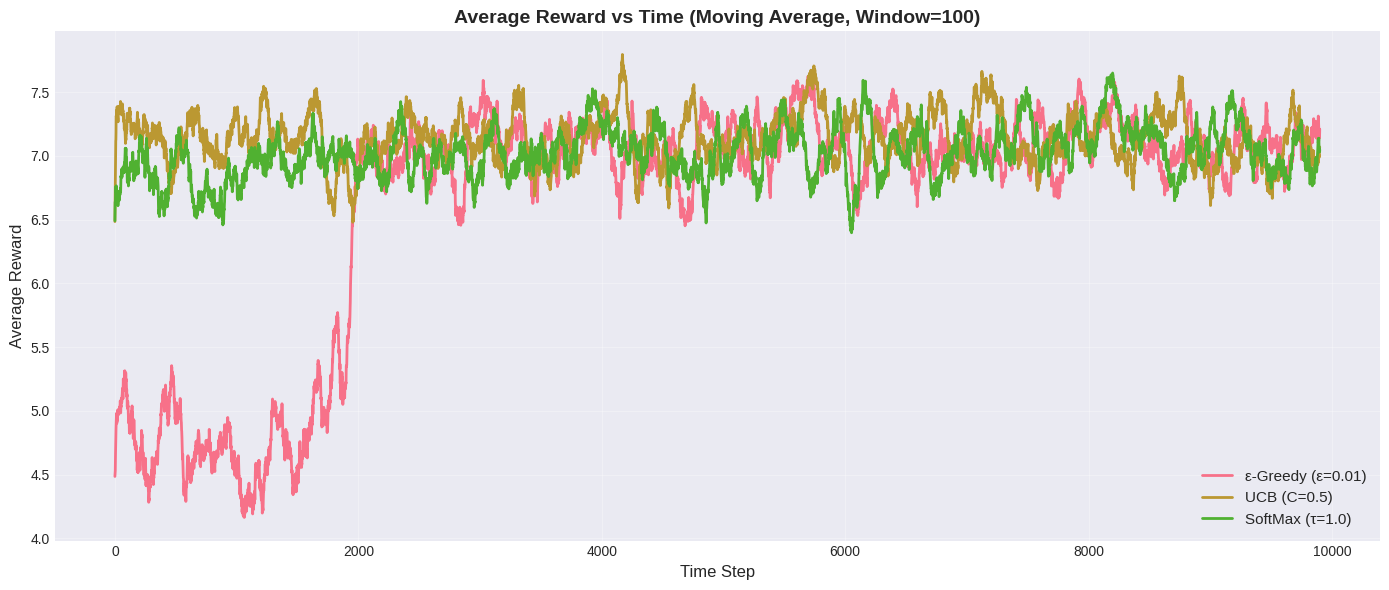


Best Epsilon-Greedy: ε=0.01, Avg Reward=6.6175
Best UCB: C=0.5, Avg Reward=7.1333
SoftMax: τ=1.0, Avg Reward=7.0203


In [46]:
# Plot 1: Average Reward vs Time for each algorithm (with best hyperparameters)
plt.figure(figsize=(14, 6))

# Calculate moving average
window = 100

# Select best hyperparameter for each algorithm (highest final reward)
best_eps = max(epsilon_values, key=lambda e: np.mean(eg_results[e]['rewards']))
best_c = max(c_values, key=lambda c: np.mean(ucb_results[c]['rewards']))

# Calculate moving averages
eg_moving_avg = np.convolve(eg_results[best_eps]['rewards'], np.ones(window)/window, mode='valid')
ucb_moving_avg = np.convolve(ucb_results[best_c]['rewards'], np.ones(window)/window, mode='valid')
sm_moving_avg = np.convolve(softmax_results[tau]['rewards'], np.ones(window)/window, mode='valid')

plt.plot(eg_moving_avg, label=f'ε-Greedy (ε={best_eps})', linewidth=2)
plt.plot(ucb_moving_avg, label=f'UCB (C={best_c})', linewidth=2)
plt.plot(sm_moving_avg, label=f'SoftMax (τ={tau})', linewidth=2)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.title('Average Reward vs Time (Moving Average, Window=100)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest Epsilon-Greedy: ε={best_eps}, Avg Reward={np.mean(eg_results[best_eps]['rewards']):.4f}")
print(f"Best UCB: C={best_c}, Avg Reward={np.mean(ucb_results[best_c]['rewards']):.4f}")
print(f"SoftMax: τ={tau}, Avg Reward={np.mean(softmax_results[tau]['rewards']):.4f}")

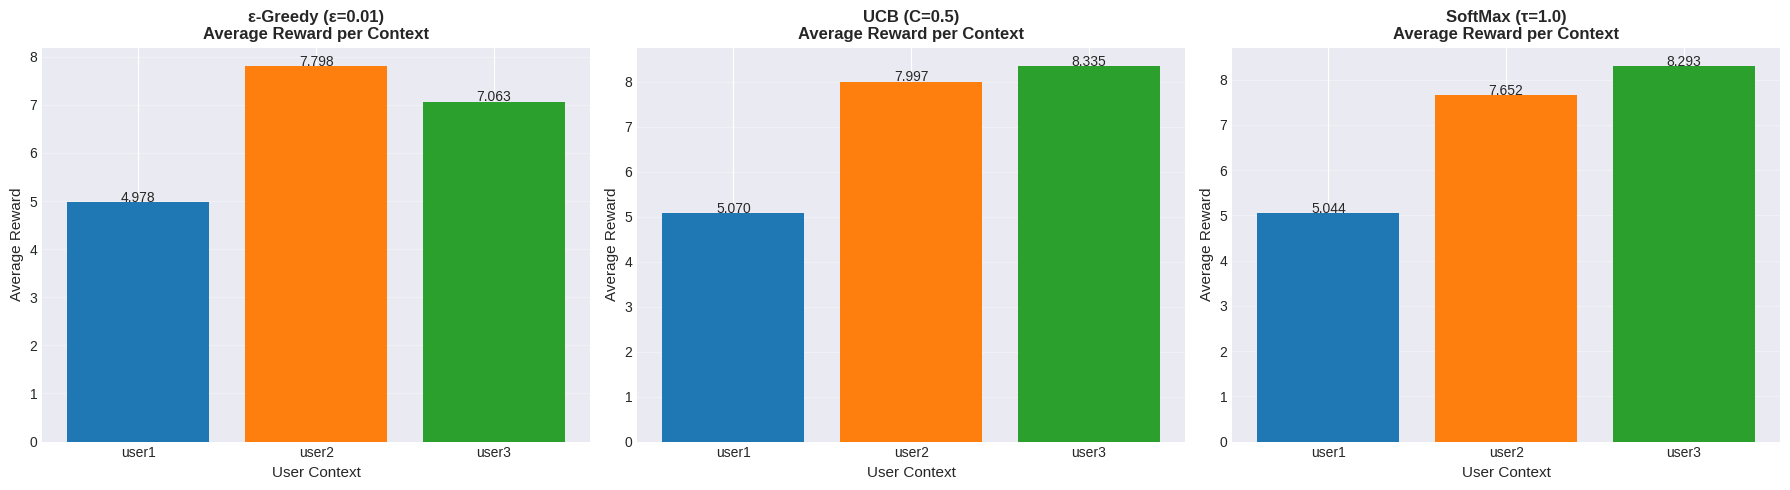

In [47]:
# Plot 2: Average Reward per Context
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

algorithms = [
    (f'ε-Greedy (ε={best_eps})', eg_results[best_eps]['context_rewards']),
    (f'UCB (C={best_c})', ucb_results[best_c]['context_rewards']),
    (f'SoftMax (τ={tau})', softmax_results[tau]['context_rewards'])
]

for idx, (name, ctx_rewards) in enumerate(algorithms):
    avg_rewards = [np.mean(ctx_rewards[ctx]) for ctx in contexts]
    axes[idx].bar(contexts, avg_rewards, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[idx].set_xlabel('User Context', fontsize=11)
    axes[idx].set_ylabel('Average Reward', fontsize=11)
    axes[idx].set_title(f'{name}\nAverage Reward per Context', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(avg_rewards):
        axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

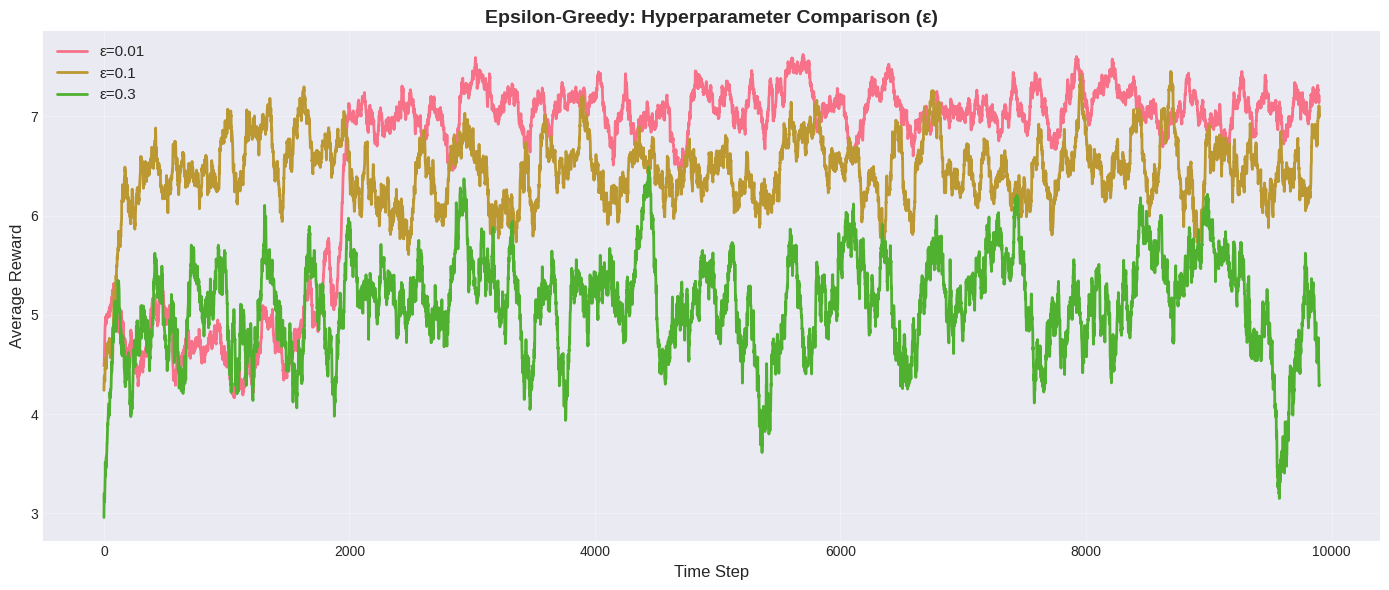


Epsilon-Greedy Final Average Rewards:
ε=0.01: 6.6175
ε=0.1: 6.4346
ε=0.3: 5.0893


In [48]:
# Plot 3: Hyperparameter Comparison for Epsilon-Greedy
plt.figure(figsize=(14, 6))

for eps in epsilon_values:
    moving_avg = np.convolve(eg_results[eps]['rewards'], np.ones(window)/window, mode='valid')
    plt.plot(moving_avg, label=f'ε={eps}', linewidth=2)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.title('Epsilon-Greedy: Hyperparameter Comparison (ε)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final average rewards
print("\nEpsilon-Greedy Final Average Rewards:")
for eps in epsilon_values:
    avg_reward = np.mean(eg_results[eps]['rewards'])
    print(f"ε={eps}: {avg_reward:.4f}")

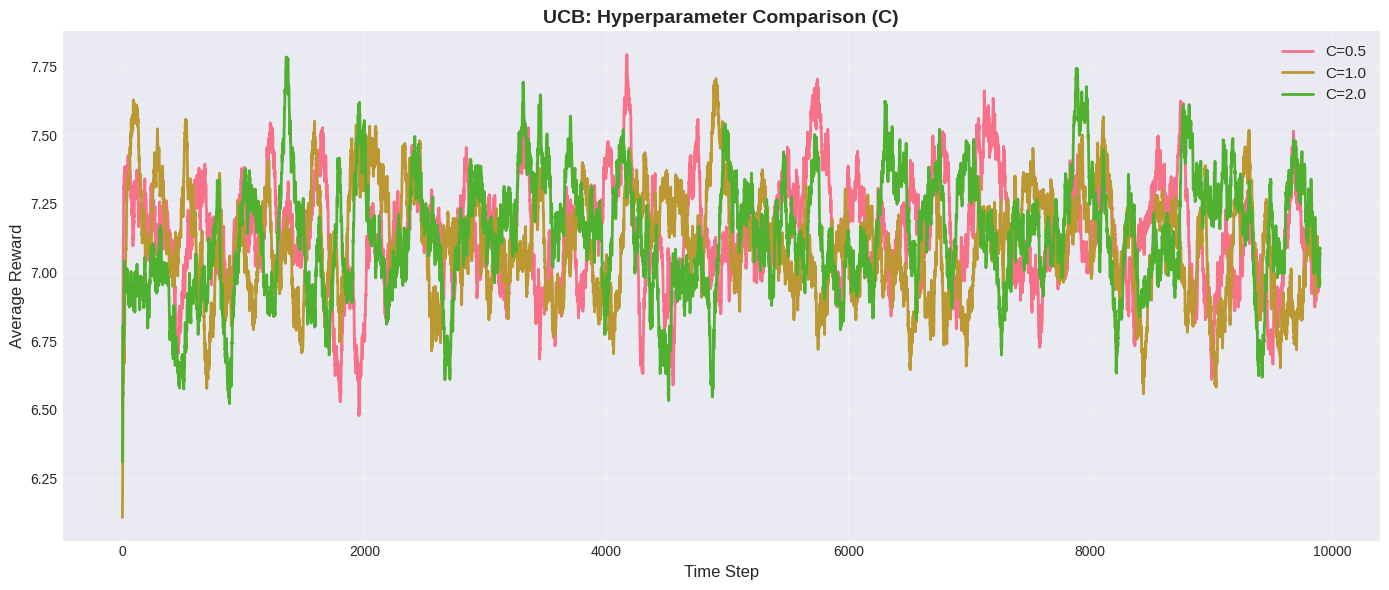


UCB Final Average Rewards:
C=0.5: 7.1333
C=1.0: 7.0952
C=2.0: 7.1279


In [49]:
# Plot 4: Hyperparameter Comparison for UCB
plt.figure(figsize=(14, 6))

for c in c_values:
    moving_avg = np.convolve(ucb_results[c]['rewards'], np.ones(window)/window, mode='valid')
    plt.plot(moving_avg, label=f'C={c}', linewidth=2)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.title('UCB: Hyperparameter Comparison (C)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final average rewards
print("\nUCB Final Average Rewards:")
for c in c_values:
    avg_reward = np.mean(ucb_results[c]['rewards'])
    print(f"C={c}: {avg_reward:.4f}")

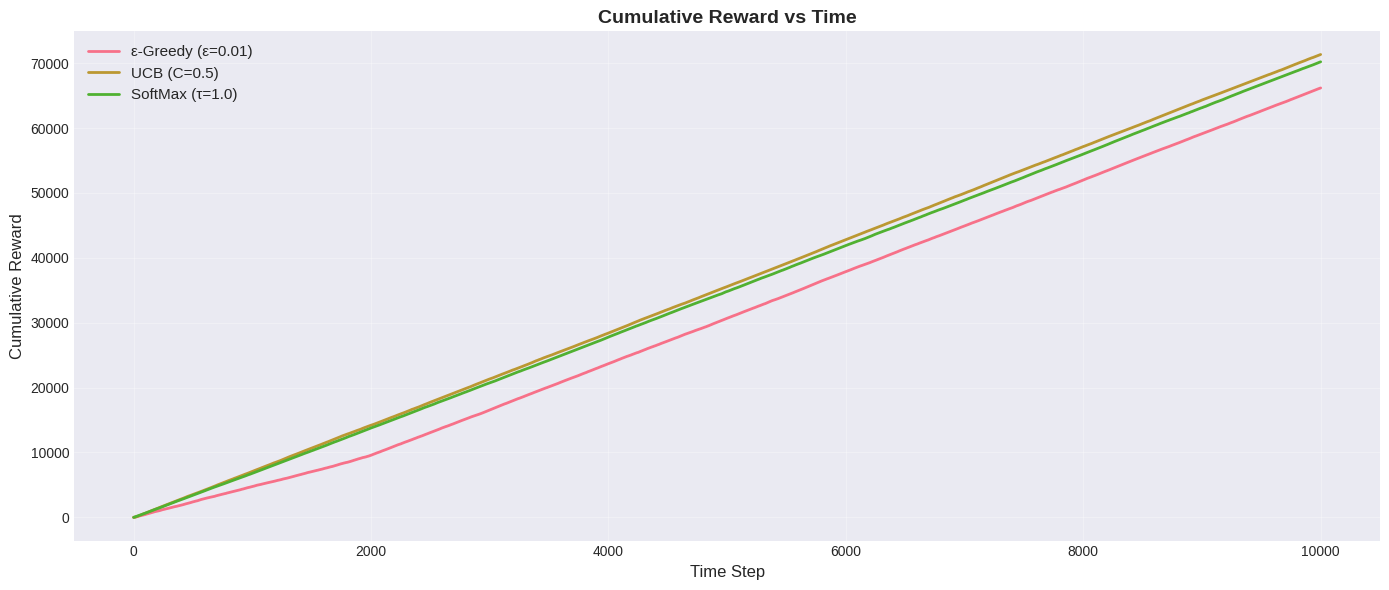


Final Cumulative Rewards:
ε-Greedy (ε=0.01): 66174.86
UCB (C=0.5): 71332.77
SoftMax (τ=1.0): 70203.09


In [50]:
# Plot 5: Cumulative Reward Comparison
plt.figure(figsize=(14, 6))

plt.plot(eg_results[best_eps]['cumulative'], label=f'ε-Greedy (ε={best_eps})', linewidth=2)
plt.plot(ucb_results[best_c]['cumulative'], label=f'UCB (C={best_c})', linewidth=2)
plt.plot(softmax_results[tau]['cumulative'], label=f'SoftMax (τ={tau})', linewidth=2)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=12)
plt.title('Cumulative Reward vs Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFinal Cumulative Rewards:")
print(f"ε-Greedy (ε={best_eps}): {eg_results[best_eps]['cumulative'][-1]:.2f}")
print(f"UCB (C={best_c}): {ucb_results[best_c]['cumulative'][-1]:.2f}")
print(f"SoftMax (τ={tau}): {softmax_results[tau]['cumulative'][-1]:.2f}")

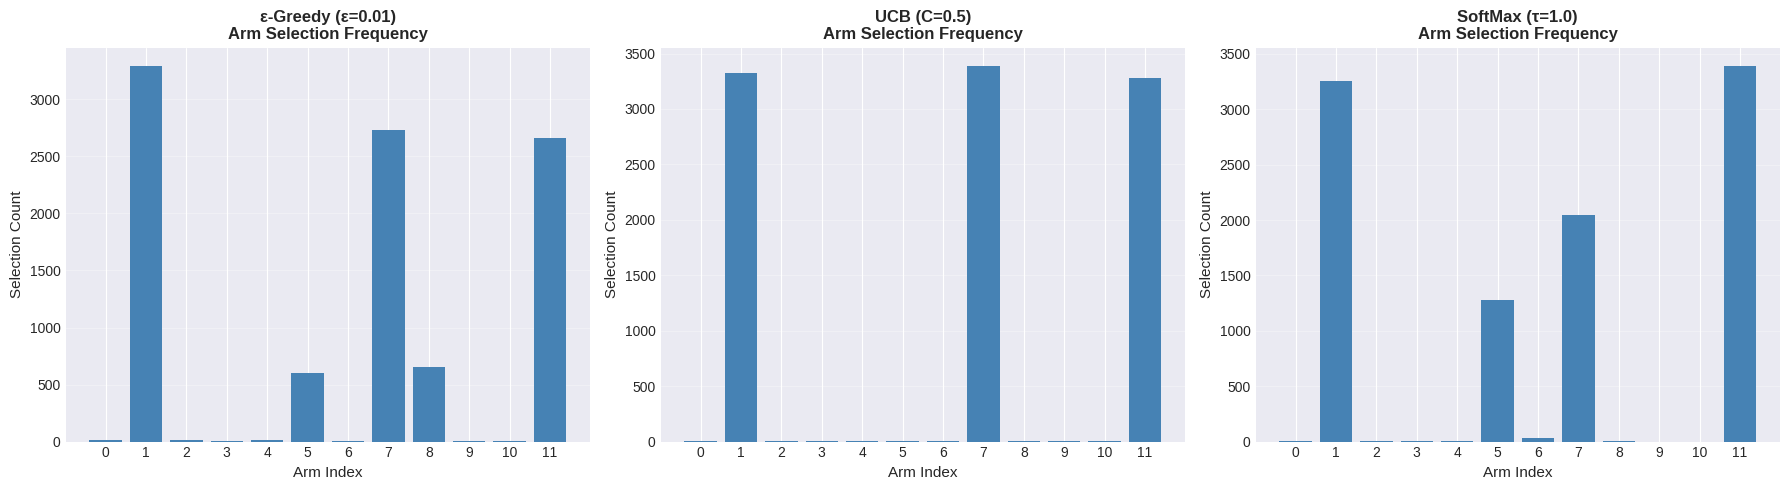

In [51]:
# Plot 6: Arm Selection Frequency
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

algorithms_data = [
    (f'ε-Greedy (ε={best_eps})', eg_results[best_eps]['N']),
    (f'UCB (C={best_c})', ucb_results[best_c]['N']),
    (f'SoftMax (τ={tau})', softmax_results[tau]['N'])
]

for idx, (name, arm_counts) in enumerate(algorithms_data):
    axes[idx].bar(range(n_arms), arm_counts, color='steelblue')
    axes[idx].set_xlabel('Arm Index', fontsize=11)
    axes[idx].set_ylabel('Selection Count', fontsize=11)
    axes[idx].set_title(f'{name}\nArm Selection Frequency', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_xticks(range(n_arms))

plt.tight_layout()
plt.show()

## Recommendation Engine

Consolidate the classification and decision-making components to establish the end-to-end operational workflow for the CMAB recommendation engine.

In [52]:
class NewsRecommendationEngine:
    def __init__(self, user_classifier, bandit, news_df, user_label_encoder, arm_mapping):
        self.user_classifier = user_classifier
        self.bandit = bandit
        self.news_df = news_df
        self.user_label_encoder = user_label_encoder
        self.arm_mapping = arm_mapping
        
    def recommend_article(self, user_features):
        """
        Recommend a news article for a given user
        
        Args:
            user_features: Dictionary or array of user features
        
        Returns:
            article: Recommended article details
            user_context: Predicted user category
            selected_category: Selected news category
        """
        # Step 1: Classify user to get context
        if isinstance(user_features, dict):
            user_array = np.array([[user_features[col] for col in feature_cols]])
        else:
            user_array = user_features.reshape(1, -1)
        
        user_context_encoded = self.user_classifier.predict(user_array)[0]
        user_context = self.user_label_encoder.inverse_transform([user_context_encoded])[0]
        
        # Step 2: Select news category using bandit
        selected_arm = self.bandit.select_arm(user_context)
        selected_category, _ = self.arm_mapping[selected_arm]
        
        # Step 3: Sample an article from the selected category
        category_articles = self.news_df[self.news_df['category'] == selected_category]
        
        if len(category_articles) > 0:
            article = category_articles.sample(n=1).iloc[0]
        else:
            # Fallback: select random article
            article = self.news_df.sample(n=1).iloc[0]
            selected_category = article['category']
        
        return article, user_context, selected_category
    
    def recommend_batch(self, user_features_list, n=5):
        """
        Recommend articles for multiple users
        
        Args:
            user_features_list: List of user feature arrays
            n: Number of users to recommend for
        
        Returns:
            recommendations: List of recommendation tuples
        """
        recommendations = []
        
        for i in range(min(n, len(user_features_list))):
            article, context, category = self.recommend_article(user_features_list[i])
            recommendations.append((article, context, category))
        
        return recommendations

print("News Recommendation Engine class defined successfully!")

News Recommendation Engine class defined successfully!


In [53]:
# Create recommendation engine with best performing bandit
# Using Epsilon-Greedy with best epsilon value
best_bandit = EpsilonGreedyBandit(n_arms, best_eps, reward_sampler, arm_mapping)

# Re-train the bandit with the simulation results
best_bandit.Q = eg_results[best_eps]['Q']
best_bandit.N = eg_results[best_eps]['N']

recommendation_engine = NewsRecommendationEngine(
    user_classifier=user_classifier,
    bandit=best_bandit,
    news_df=news_df_clean,
    user_label_encoder=user_label_encoder,
    arm_mapping=arm_mapping
)

print("Recommendation Engine initialized with best performing algorithm!")
print(f"Using: ε-Greedy with ε={best_eps}")

Recommendation Engine initialized with best performing algorithm!
Using: ε-Greedy with ε=0.01


In [54]:
# Test the recommendation engine with sample users
print("\n" + "="*80)
print("TESTING RECOMMENDATION ENGINE")
print("="*80)

# Get 5 random test users
sample_users = X_test.sample(n=5)

for idx, (_, user_features) in enumerate(sample_users.iterrows(), 1):
    article, user_context, selected_category = recommendation_engine.recommend_article(user_features.values)
    
    print(f"\nUser {idx}:")
    print(f"  Predicted Context: {user_context}")
    print(f"  Selected Category: {selected_category}")
    print(f"  Recommended Article:")
    
    # Display article details
    for col in article.index:
        if col not in ['user_id', 'article_id']:  # Skip ID columns
            value = article[col]
            if isinstance(value, str) and len(value) > 100:
                value = value[:100] + "..."
            print(f"    {col}: {value}")
    print("-" * 80)


TESTING RECOMMENDATION ENGINE

User 1:
  Predicted Context: user_2
  Selected Category: POLITICS
  Recommended Article:
    link: https://www.huffingtonpost.com/entry/clinton-eyeing-general-election-fight-with-trump_us_56d31282e4b...
    headline: Clinton Eyeing General Election Fight With Trump
    category: POLITICS
    short_description: Clinton made it clear on Saturday she was already thinking about taking on the real estate mogul.
    authors: John Whitesides and Amanda Becker, Reuters
    date: 2016-02-28 00:00:00
--------------------------------------------------------------------------------

User 2:
  Predicted Context: user_2
  Selected Category: SPORTS
  Recommended Article:
    link: https://www.huffingtonpost.com/entry/golden-state-warriors-undefeated_us_565fa7fde4b072e9d1c4c185
    headline: Golden State Warriors Remain Undefeated
    category: SPORTS
    short_description: Their magical season continues.
    authors: Steve Reed, AP
    date: 2015-12-03 00:00:00
-------

## Key Takeaways

### Comparing the Algorithms

**Epsilon-Greedy:**
- A straightforward and easy-to-understand approach to balancing exploration and exploitation  
- Effectiveness depends strongly on the chosen epsilon value  
- Smaller epsilon (e.g., 0.01) prioritizes exploitation  
- Larger epsilon (e.g., 0.3) increases exploration but can reduce short-term rewards  

**UCB (Upper Confidence Bound):**
- Explores in a principled way using uncertainty estimates  
- Naturally maintains a balance between exploration and exploitation  
- The parameter C determines how aggressively it explores  
- Frequently delivers strong results with minimal manual tuning  

**Softmax:**
- Chooses actions probabilistically based on value estimates  
- The temperature parameter (τ) sets the level of randomness  
- Provides a gradual shift from exploration to exploitation  
- Can be affected by the scale of Q-values  

### Sensitivity to Hyperparameters

**Epsilon (ε-Greedy):**
- Low (0.01): Learns quickly but risks overlooking the best option  
- Moderate (0.1): Often a practical middle ground  
- High (0.3): Encourages heavy exploration but slows convergence  

**C (UCB):**
- Low (0.5): Favors exploitation and faster convergence  
- Moderate (1.0): Balanced behavior  
- High (2.0): Promotes exploration and may improve long-term gains  

### Advantages and Drawbacks

**Advantages:**
1. Contextual bandits tailor recommendations to user segments  
2. Online updates enable continuous learning  
3. Algorithms are lightweight and efficient  
4. They do not require massive historical data  

**Drawbacks:**
1. They assume reward distributions remain stable  
2. Performance relies on accurate context classification  
3. Cold-start issues arise for new users or items  
4. Basic features may fail to capture complex behaviors  

### Production Suggestions

1. **Choosing an Algorithm:** UCB is often a reliable default with limited tuning  
2. **Tuning Parameters:** Select hyperparameters using validation data  
3. **Using Ensembles:** Combining bandits can improve robustness  
4. **Richer Context:** Add more user features to improve decisions  
5. **Regular Updates:** Refresh models as preferences shift  
6. **A/B Testing:** Measure real-world impact before full rollout  

### Final Note

Contextual bandits are effective for managing the exploration–exploitation trade-off in news recommendation. The best setup depends on:
- Compute and system constraints  
- Desired balance between exploration and reward  
- How stable user preferences are  
- Real-time serving requirements  
```}


In [55]:
# Summary Statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nUser Classification Accuracy: {accuracy:.4f}")

print("\nBest Algorithm Performance (Average Reward):")
algorithms_summary = [
    (f"ε-Greedy (ε={best_eps})", np.mean(eg_results[best_eps]['rewards'])),
    (f"UCB (C={best_c})", np.mean(ucb_results[best_c]['rewards'])),
    (f"SoftMax (τ={tau})", np.mean(softmax_results[tau]['rewards']))
]

algorithms_summary.sort(key=lambda x: x[1], reverse=True)

for rank, (name, avg_reward) in enumerate(algorithms_summary, 1):
    print(f"{rank}. {name}: {avg_reward:.4f}")

print("\nLearned Q-values (Expected Rewards) per Arm:")
best_algorithm = algorithms_summary[0][0]
if 'ε-Greedy' in best_algorithm:
    best_Q = eg_results[best_eps]['Q']
elif 'UCB' in best_algorithm:
    best_Q = ucb_results[best_c]['Q']
else:
    best_Q = softmax_results[tau]['Q']

for arm in range(n_arms):
    category, context = arm_mapping[arm]
    print(f"Arm {arm:2d} ({category:15s}, {context}): Q={best_Q[arm]:.4f}")

print("\n" + "="*80)
print("Lab 3 Completed Successfully!")
print("="*80)


SUMMARY STATISTICS

User Classification Accuracy: 0.8975

Best Algorithm Performance (Average Reward):
1. UCB (C=0.5): 7.1333
2. SoftMax (τ=1.0): 7.0203
3. ε-Greedy (ε=0.01): 6.6175

Learned Q-values (Expected Rewards) per Arm:
Arm  0 (Entertainment  , user_1): Q=-4.4459
Arm  1 (Education      , user_1): Q=5.0774
Arm  2 (Tech           , user_1): Q=-0.9461
Arm  3 (Crime          , user_1): Q=-2.4031
Arm  4 (Entertainment  , user_2): Q=-4.5923
Arm  5 (Education      , user_2): Q=7.1906
Arm  6 (Tech           , user_2): Q=3.6019
Arm  7 (Crime          , user_2): Q=8.0026
Arm  8 (Entertainment  , user_3): Q=0.9576
Arm  9 (Education      , user_3): Q=-6.0584
Arm 10 (Tech           , user_3): Q=-5.5869
Arm 11 (Crime          , user_3): Q=8.3460

Lab 3 Completed Successfully!
